In [31]:
import pandas as pd
import numpy as np

import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
%matplotlib inline
pd.set_option('display.max_columns', 100)

# Load and Clean Raw

In [2]:
def df_loader(csv_path):
    '''
    PARAMETERS
    ----------
    csv_path
        - str
        
    RETURNS
    -------
    df
        - pandas dataframe
    
    Loads up the raw data
    Expands the json columns
    Returns the df
    '''
    # Load
    convert_cols = ['device', 'geoNetwork', 'totals', 'trafficSource']
    converters = {col: json.loads for col in convert_cols}
    df = pd.read_csv(csv_path, converters=converters, dtype={'fullVisitorId': 'str'})

    # json
    for col in convert_cols:
        df_col = json_normalize(df[col])
        df_col.columns = [f"{col}.{sub_col}" for sub_col in df_col.columns]
        df = df.drop(col, axis=1).merge(df_col, right_index=True, left_index=True)
    
    return df

In [3]:
# comment this out when not running

# df_train = df_loader('../data/train.csv') 
# print(df_train.shape)
# df_train.head()

(903653, 55)


,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,device.browserVersion,device.deviceCategory,device.flashVersion,device.isMobile,device.language,device.mobileDeviceBranding,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.mobileDeviceModel,device.mobileInputSelector,device.operatingSystem,device.operatingSystemVersion,device.screenColors,device.screenResolution,geoNetwork.city,geoNetwork.cityId,geoNetwork.continent,geoNetwork.country,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.networkLocation,geoNetwork.region,geoNetwork.subContinent,totals.bounces,totals.hits,totals.newVisits,totals.pageviews,totals.transactionRevenue,totals.visits,trafficSource.adContent,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Izmir,not available in demo dataset,Asia,Turkey,not available in demo dataset,not available in demo dataset,(not set),ttnet.com.tr,not available in demo dataset,Izmir,Western Asia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Oceania,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,Australasia,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,not available in demo dataset,not available in demo dataset,Madrid,not available in demo dataset,Europe,Spain,not available in demo dataset,not available in demo dataset,(not set),unknown.unknown,not available in demo dataset,Community of Madrid,Southern Europe,1,1,1,1,NaN,1,NaN,NaN,not available in demo dataset,NaN,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,desktop,not available in demo dataset,False,not a

This will be the first version of the cleaned data

In [7]:
# df_train.to_csv('../data/train_clean_v1.csv', index=False)

## Explore Revenue

In [19]:
dtypes = {'fullVisitorId': 'str', 'totals.transactionRevenue': 'float', 'trafficSource.campaignCode': 'str'}
df_train = pd.read_csv('../data/train_clean_v1.csv', dtype=dtypes)

Most users don't purchase anything

Text(0.5,1,'Purchase of each Visit')

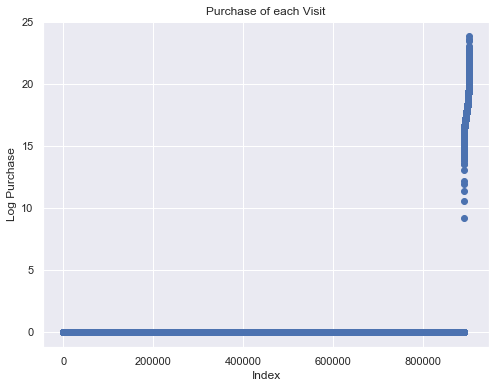

In [50]:
vals = df_train['totals.transactionRevenue'].sort_values().values
vals = np.log1p(vals)

plt.figure(figsize=(8, 6))
plt.scatter(x=range(len(vals)), y=vals)
plt.xlabel('Index')
plt.ylabel('Log Purchase')
plt.title('Purchase of each Visit')

Most visits don't result in a purchase

# Impute & Drop

Going to look at columns with nulls and single-value columns. If they don't have much data that pertains to visits that resulted in a purchase then they'll likely get dropped. Notes on each column in question are below.

In [51]:
df_train.isnull().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserSize                                        0
device.browserVersion                                     0
device.deviceCategory                                     0
device.flashVersion                                       0
device.isMobile                                           0
device.language                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceInfo                 

In [72]:
null_cols = df_train.columns[df_train.isna().any()].tolist()
sv_cols = [col for col in df_train.columns if df_train[col].nunique() == 1]

In [96]:
def col_looker(col):
    '''
    PARAMETERS:
    -----------
    col
        - str, the column to inspect
    
    
    Prints a written report of the percent of null values and single value
    between the purchasers and non-purchasers
    '''
    
    df_purch = df_train[df_train['totals.transactionRevenue'] > 0]
    df_no_purch = df_train[df_train['totals.transactionRevenue'] == 0]
    
    # Nulls
    purch_null = len(df_purch[df_purch[col].isnull()])
    purch_null = round(purch_null / len(df_purch), 2)
    no_purch_null = len(df_no_purch[df_no_purch[col].isnull()])
    no_purch_null = round(no_purch_null / len(df_no_purch), 2)

    print('-' * 50 + '\n' + col + '\n')
    print('Purchase % Null:\t', purch_null)
    print('No Purchase % Null:\t', no_purch_null)
    
    # Single Values
    if purch_null < 1:
        val = df_purch[col].value_counts().index[0]
        purch_sv = len(df_purch[df_purch[col] == val])
        purch_sv = round(purch_sv / len(df_purch), 2)
    else:
        val = 'N/A'
        purch_sv = 'N/A'
    print('Purchase % SV:\t\t', purch_sv)
    print(val)
    
    if no_purch_null < 1:
        val = df_no_purch[col].value_counts().index[0]
        no_purch_sv = len(df_no_purch[df_no_purch[col] == val])
        no_purch_sv = round(no_purch_sv / len(df_no_purch), 2)
    else:
        val = 'N/A'
        no_purch_sv = 'N/A'
    print('No Purchase % SV:\t', no_purch_sv)
    print(val)

In [95]:
col = 'device.browserSize'
val = df_purch[col].value_counts().index[0]
print(val)
purch_sv = len(df_purch[df_purch[col] == val])
print(purch_sv)
purch_sv = round(purch_sv / len(df_purch), 2)
print(purch_sv)
df_train[col].value_counts()

not available in demo dataset
11515
1.0


not available in demo dataset    903653
Name: device.browserSize, dtype: int64

In [97]:
cols_to_check = [col for col in df_train.columns if col in set(null_cols + sv_cols)]
for col in cols_to_check:
    col_looker(col)

--------------------------------------------------
socialEngagementType

Purchase % Null:	 0.0
No Purchase % Null:	 0.0
Purchase % SV:		 1.0
Not Socially Engaged
No Purchase % SV:	 1.0
Not Socially Engaged
--------------------------------------------------
device.browserSize

Purchase % Null:	 0.0
No Purchase % Null:	 0.0
Purchase % SV:		 1.0
not available in demo dataset
No Purchase % SV:	 1.0
not available in demo dataset
--------------------------------------------------
device.browserVersion

Purchase % Null:	 0.0
No Purchase % Null:	 0.0
Purchase % SV:		 1.0
not available in demo dataset
No Purchase % SV:	 1.0
not available in demo dataset
--------------------------------------------------
device.flashVersion

Purchase % Null:	 0.0
No Purchase % Null:	 0.0
Purchase % SV:		 1.0
not available in demo dataset
No Purchase % SV:	 1.0
not available in demo dataset
--------------------------------------------------
device.language

Purchase % Null:	 0.0
No Purchase % Null:	 0.0
Purchase 